˙ pre_trained vgg16에 dropout층 추가 </br>
 vgg16_practice:: momentum 0.9 설정

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import SGD

In [3]:
# numpy 데이터를 불러와서 shape 확인
X_train, X_test, y_train, y_test = np.load("/content/drive/My Drive/practice7_data.npy", allow_pickle=True)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')  # X_train: (20802, 64, 64, 3), y_train: (20802, 5)
print(f'X_test: {X_test.shape}, y_train: {y_test.shape}')  # X_test: (5201, 64, 64, 3), y_train: (5201, 5)

X_train: (20802, 64, 64, 3), y_train: (20802, 5)
X_test: (5201, 64, 64, 3), y_train: (5201, 5)


In [0]:
# 데이터 정규화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

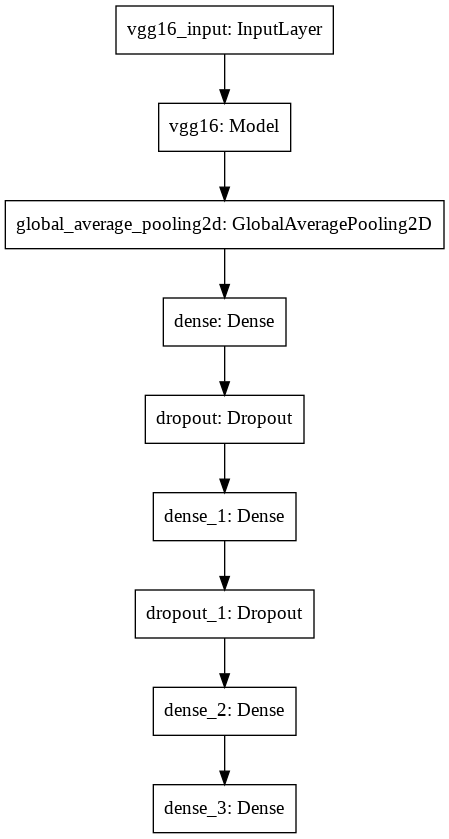

In [5]:
# 3. 이미 훈련된 vgg16 모델에 globalaveragepooling2d, dense 연결해서 사용
pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])
# include_top: 네트워크의 최상단에 3개의 완전 연결 레이어를 넣을지 여부
# input_shape: include_top이 False일 경우만 특정. 그렇지 않다면 인풋의 형태가 (224, 224, 3)이어야 함.
pre_trained_vgg.trainable = False # 이미지넷으로 학습된 값들을 그대로 사용할 것이기 때문에
pre_trained_vgg.summary()

additional_model = Sequential()
additional_model.add(pre_trained_vgg)

# pre_trained_vgg의 디폴트된 input_shape과 다른 형태를 넣었기 때문에 Flatten()대신 Global AveragePooling2D() 이용. 이 부분은 더 공부 필요
additional_model.add(GlobalAveragePooling2D()) 
additional_model.add(Dense(4096, activation='relu'))
additional_model.add(Dropout(0.5))
additional_model.add(Dense(4096, activation='relu'))
additional_model.add(Dropout(0.5))
additional_model.add(Dense(1000, activation='relu'))
additional_model.add(Dense(5, activation='softmax'))
additional_model.summary()
plot_model(additional_model, to_file='practice_1.png')

In [0]:
additional_model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.7, clipvalue=0.5), metrics=['accuracy']) # 'sgd'

model_dir = "./drive/My Drive/Colab Notebooks/model/"
model_path = model_dir + 'practice12.model'
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [9]:
history = additional_model.fit(X_train, y_train, batch_size=100, epochs=100, callbacks=[checkpoint, early_stop],
                        validation_split=0.2)

Train on 16641 samples, validate on 4161 samples
Epoch 1/100
16600/16641 [============================>.] - ETA: 0s - loss: 1.3260 - accuracy: 0.4445
Epoch 00001: val_loss improved from inf to 1.05913, saving model to ./drive/My Drive/Colab Notebooks/model/practice12.model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./drive/My Drive/Colab Notebooks/model/practice12.model/assets
16641/16641 [==============================] - 17s 1ms/sample - loss: 1.3261 - accuracy: 0.4443 - val_loss: 1.0591 - val_accuracy: 0.5898
Epoch 2/100
16500/16641 [============================>.] - ETA: 0s - loss: 1.0133 - accuracy: 0.5946
Epoch 00002: val_loss improved from 1.05913 to 0.93789, saving model to ./drive/My Drive/Colab Notebooks/model/practice12.model
INFO:tensorflow:Assets written to: ./drive/My Drive/Colab Notebooks/model/practice12.model/assets
16641/16641 [==============================] - 9s 545us/sample - loss: 1.0128 - ac

In [10]:
# test 데이터의 loss, accuracy
eval = additional_model.evaluate(X_test, y_test)
print(f'Test loss: {eval[0]}, accuracy: {eval[1]}')

5201/5201 [==============================] - 2s 466us/sample - loss: 0.5019 - accuracy: 0.8102
Test loss: 0.501913208430649, accuracy: 0.8102288246154785


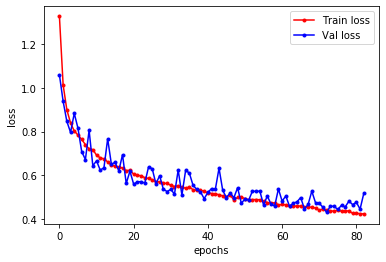

In [11]:
# train 데이터, validation 데이터의 손실 그래프
train_loss = history.history['loss']
val_loss = history.history['val_loss']
x_len = range(len(train_loss))
plt.plot(x_len, train_loss, marker='.', color='red', label='Train loss')
plt.plot(x_len, val_loss, marker='.', color='blue', label='Val loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

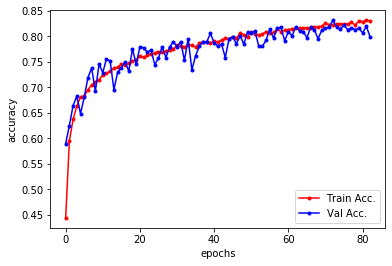

In [13]:
 # train 데이터, validation 데이터의 정확도 그래프
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(x_len, train_acc, marker='.', c='red', label='Train Acc.')
plt.plot(x_len, val_acc, marker='.', c='blue', label='Val Acc.')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [0]:
# 4. 만든 모델 불러와서 예측 후 평가
model = load_model(model_path)

In [15]:
predictions = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
print('* Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

* Confusion Matrix
[[ 829   74   64    1   40]
 [  61  740  231    8   15]
 [  64  149  803    7   11]
 [  23   16   16 1072   24]
 [  24    2   15   14  898]]


In [16]:
print('* Classification Report')
print(classification_report(y_test, y_pred, target_names=os.listdir('/content/drive/My Drive/Final'))) # target_names=['df', 'mel', 'nv', 'tsu', 'vl']


* Classification Report
              precision    recall  f1-score   support

       nevus       0.83      0.82      0.83      1008
          df       0.75      0.70      0.73      1055
      eschar       0.71      0.78      0.74      1034
          vl       0.97      0.93      0.95      1151
         mel       0.91      0.94      0.93       953

    accuracy                           0.83      5201
   macro avg       0.84      0.83      0.83      5201
weighted avg       0.84      0.83      0.84      5201

